In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime as dt
import json

## 퀀트함수
from quant_functions import anal_funcs, data_funcs
import portfolio_obtimizer
import myfuncs
from fredapi import Fred
fred = Fred(api_key='cfb4f49f5c1a9396f671b8049d992e56')

# 시각화 관련
import plotly_express as px
import plotly.figure_factory as ff
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')
import plotly.graph_objects as go
import seaborn as sns
sns.set_style('whitegrid')
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mticker
from matplotlib.ticker import LogLocator
import matplotlib.pyplot as plt
## figure size 설정
figsize=(12, 8)
plt.rcParams["figure.figsize"] = figsize
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

import graphModule as gm

## color 설정
with open('colors.json') as f:
    mycolors = json.load(f)

# 블루 테마
cmap_colors = ["#FFFFFF", mycolors['color_cont3'], mycolors['color_cont2']]
# LinearSegmentedColormap 생성
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", cmap_colors, N=256)    

## shock case
with open('shockCase.json', encoding='utf-8') as f:
    shock_cases = json.load(f)

## Data Load

In [2]:
## 보간용 필수 데이터
gold = pd.read_csv(f"gold.csv", encoding='utf-8').set_index('Date')[['Close']].rename(columns={'Close':'Gold'})
gold.index = pd.to_datetime(gold.index)
div = pd.read_csv(f"div.csv", encoding='utf-8').set_index('Date')[['Close']].rename(columns={'Close':'Div'})
div.index = pd.to_datetime(div.index)
ds20 = fred.get_series('DGS20')
ds10 = fred.get_series('DGS10')

## load data
df_ref = data_funcs.get_merged_df('^IXIC', '^GSPC', '^DJI', 'GC=F')
df_ref = df_ref.fillna(method = 'pad')
df_ref['Div'] = div['Div']
df_ref['Gold'] = gold['Gold']
df_ref['DGS10'] = ds10
df_ref['DGS20'] = ds20

## Imputation
df_ref = myfuncs.imputation(df_ref, '^GSPC', '^DJI')
df_ref = myfuncs.imputation(df_ref, '^DJI', 'Div')
df_ref = myfuncs.imputation(df_ref, 'DGS10', 'DGS20')
df_ref = myfuncs.imputation(df_ref, 'DGS20', 'DGS10')
df_ref = myfuncs.imputation(df_ref, 'GC=F', 'Gold')
df_ref['Gold']['1975-01-02'] = 1
df_ref['Gold']['1975-01-03'] = 1

## column selection
df_ref = df_ref[['^GSPC', '^DJI', '^IXIC', 'Div', 'DGS10', 'DGS20', 'Gold']]
df_ref.columns = ['S&P500', 'DowJones', 'NASDAQ', 'Div', 'DGS10', 'DGS20', 'Gold']

## 75년 이전에는 Gold 데이터가 없음
df_ref = df_ref['1975':]
df_ref = df_ref/df_ref.iloc[0]

[*********************100%%**********************]  4 of 4 completed

0.9188812313195373
0.8698779253276526
0.7566412396530307
1.1913259524589033
0.9953424146502147


In [3]:
## 프로젝트마다 필요한 데이터
tickers = ['QQQ', 'SPY', 'TQQQ', 'TLT']
df_ori = data_funcs.get_merged_df(*tickers)
df_ori = df_ori[tickers]

[*********************100%%**********************]  4 of 4 completed


In [4]:
## 보간 시계열 데이터
df_imp = pd.concat([df_ref, df_ori], axis=1)
df_imp = myfuncs.imputation(df_imp, 'NASDAQ', 'QQQ')
df_imp = myfuncs.imputation(df_imp, 'S&P500', 'SPY')
df_imp = myfuncs.imputation(df_imp, 'QQQ', 'TQQQ')
df_imp = myfuncs.imputation(df_imp, 'DGS20', 'TLT')


## 비보간 시계열 데이터
df_cut = df_ori.dropna()
df_cut = df_cut/df_cut.iloc[0]

1.044888453214904
0.9936330541434834
2.9807033516282933
-0.41939010420252615


## Data Selection

In [5]:
## assets = ['JEPQ', 'QQQ']
assets = ['TQQQ', 'QQQ']

In [214]:
# plot_df = df_imp.copy()
# plot_df = df_imp['1999':].copy()
# plot_df = df_imp['1999':'2007'].copy()
plot_df = df_imp['2007':].copy()
# plot_df = df_imp['2015':].copy()
# plot_df = df_cut[:]
plot_df = plot_df/plot_df.iloc[0]
highlight_periods = [(shock_cases['1차오일쇼크_t0'], shock_cases['1차오일쇼크_t1']),
                     (shock_cases['2차오일쇼크_t0'], shock_cases['2차오일쇼크_t1']),
                     (shock_cases['물가충격_t0'], shock_cases['물가충격_t1']),
                     (shock_cases['걸프전_t0'], shock_cases['걸프전_t1']),
                     (shock_cases['닷컴버블_t0'], shock_cases['닷컴버블_t1']),
                     (shock_cases['금융위기_t0'], shock_cases['금융위기_t1']),
                     (shock_cases['코로나_t0'], shock_cases['코로나_t1'])]

# highlight_periods = [
#                      (shock_cases['금융위기_t0'], shock_cases['금융위기_t1']),
#                      (shock_cases['코로나_t0'], shock_cases['코로나_t1'])]

## Visualization

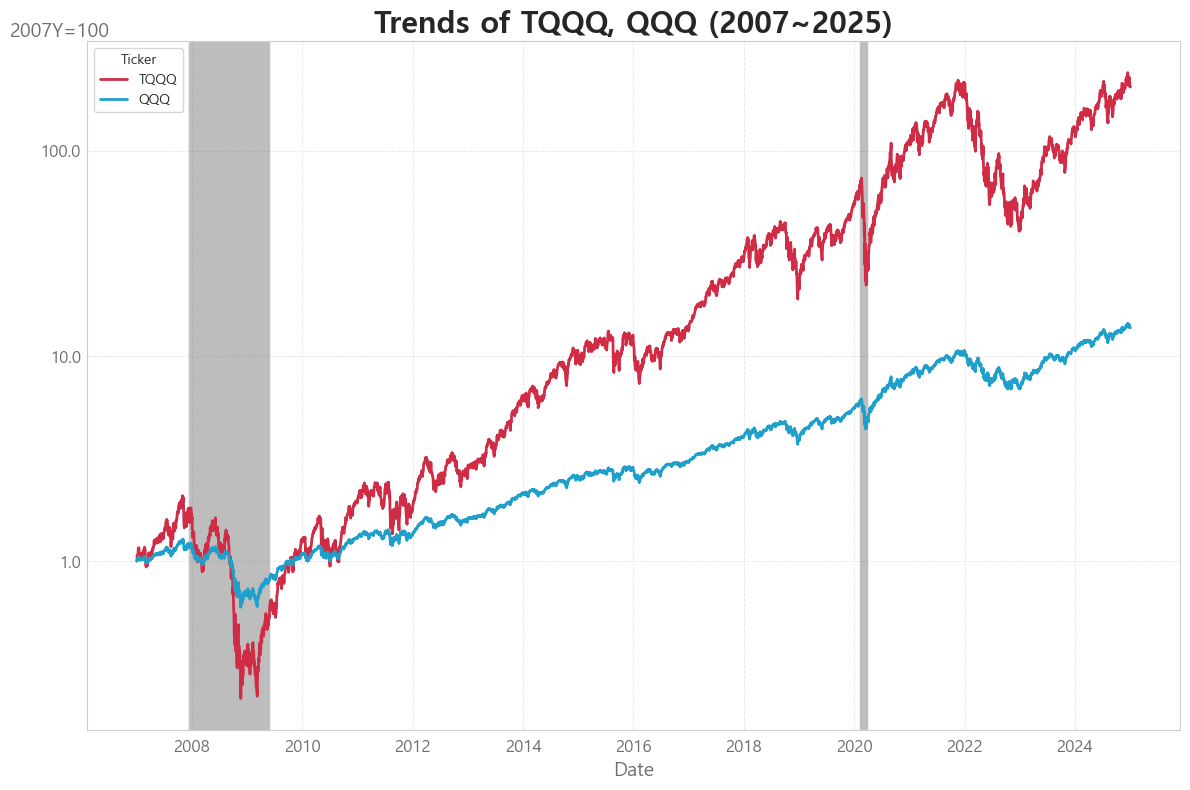

In [215]:
gm.trend_plot(plot_df, assets, highlight_periods=highlight_periods, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

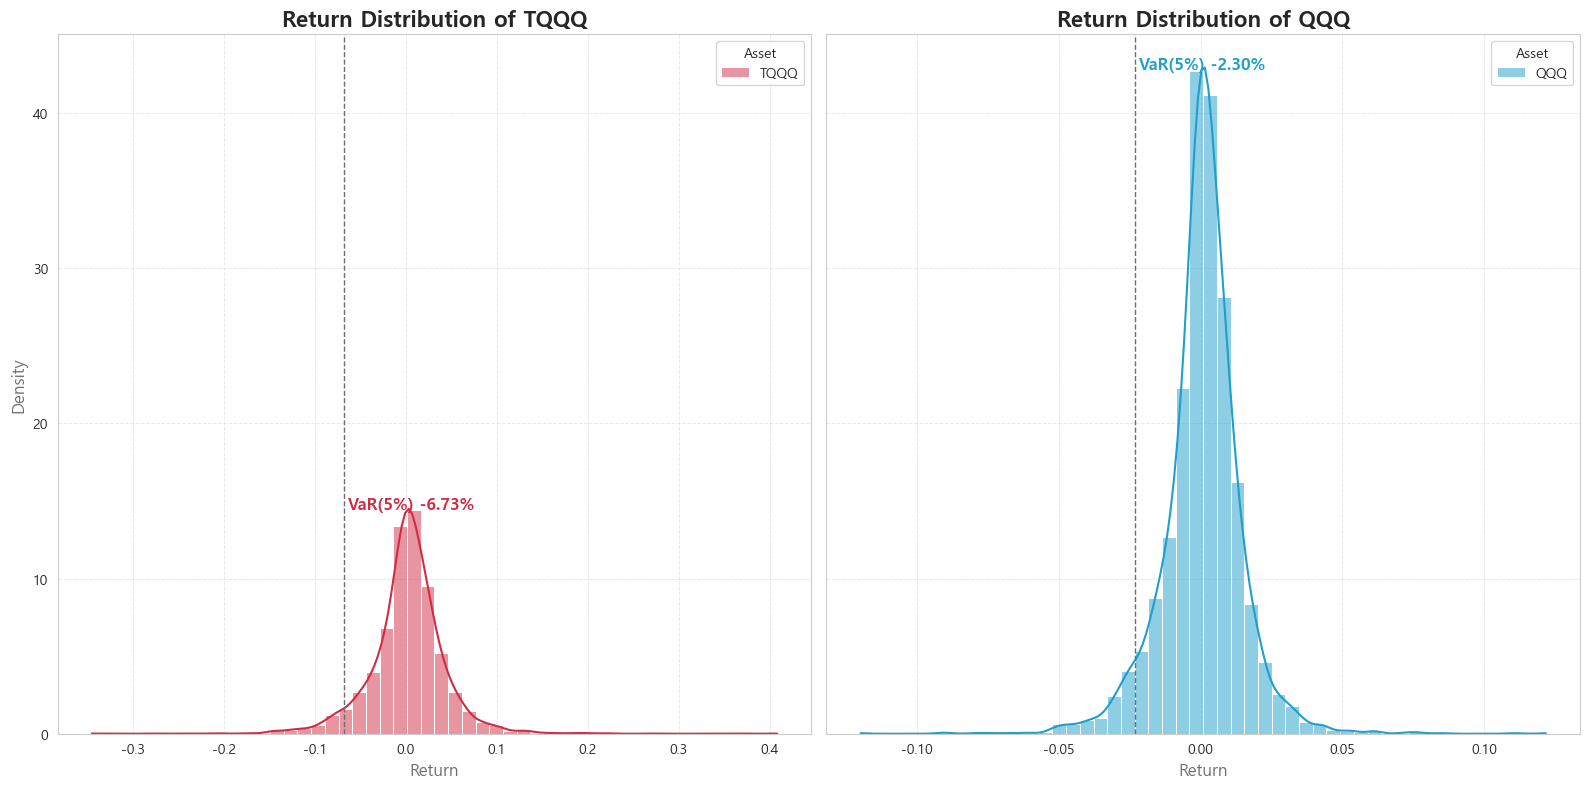

In [216]:
gm.asset_histogram_plot(plot_df.pct_change(), assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

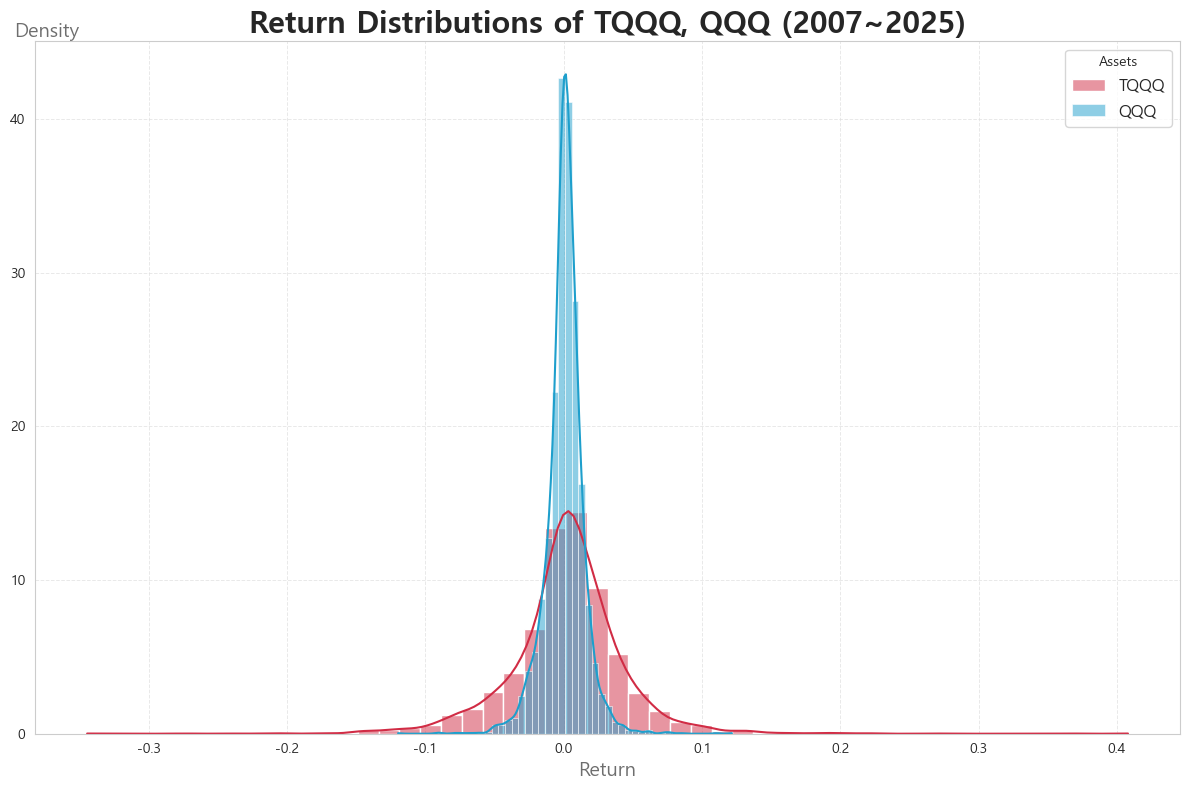

In [217]:
gm.asset_histogram_merged_plot(plot_df.pct_change(), assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

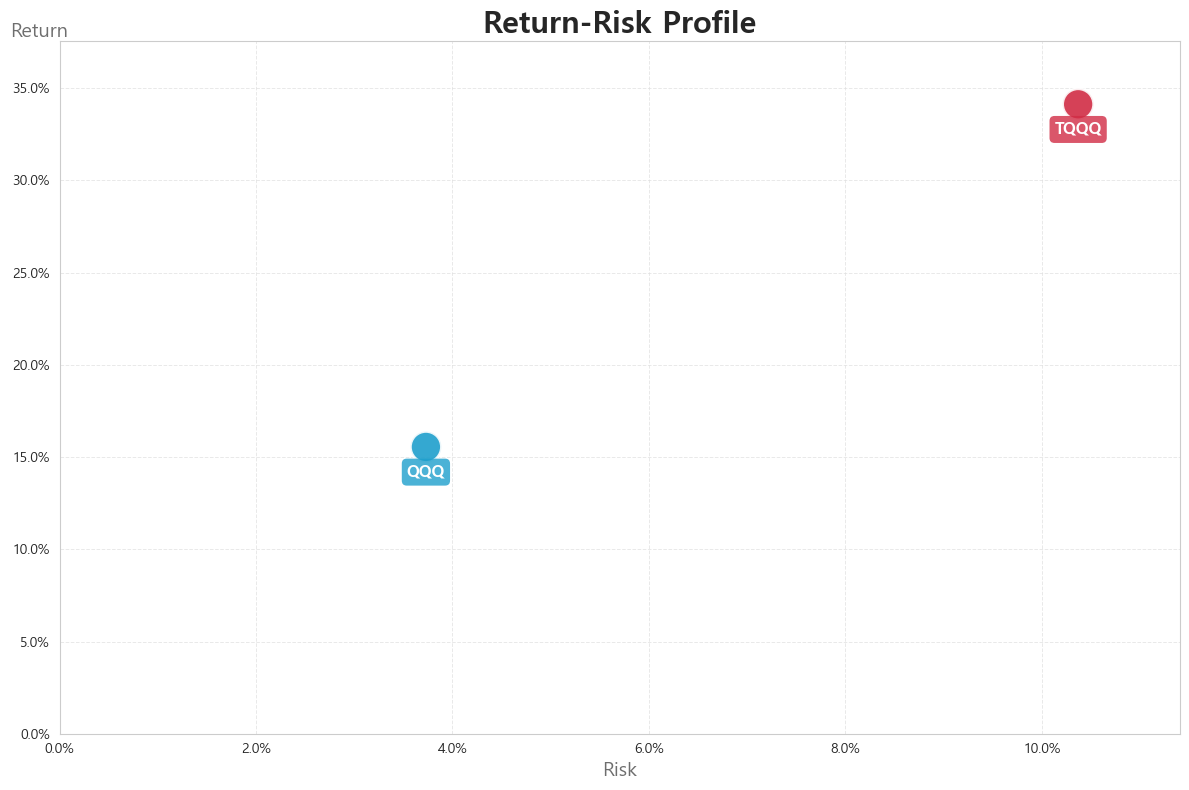

In [218]:
return_risk_df = anal_funcs.get_Vol_report(plot_df[assets], method='a', rf=0)
# gm.return_risk_profile_plot(return_risk_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])
gm.return_risk_profile_plot(return_risk_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont']])

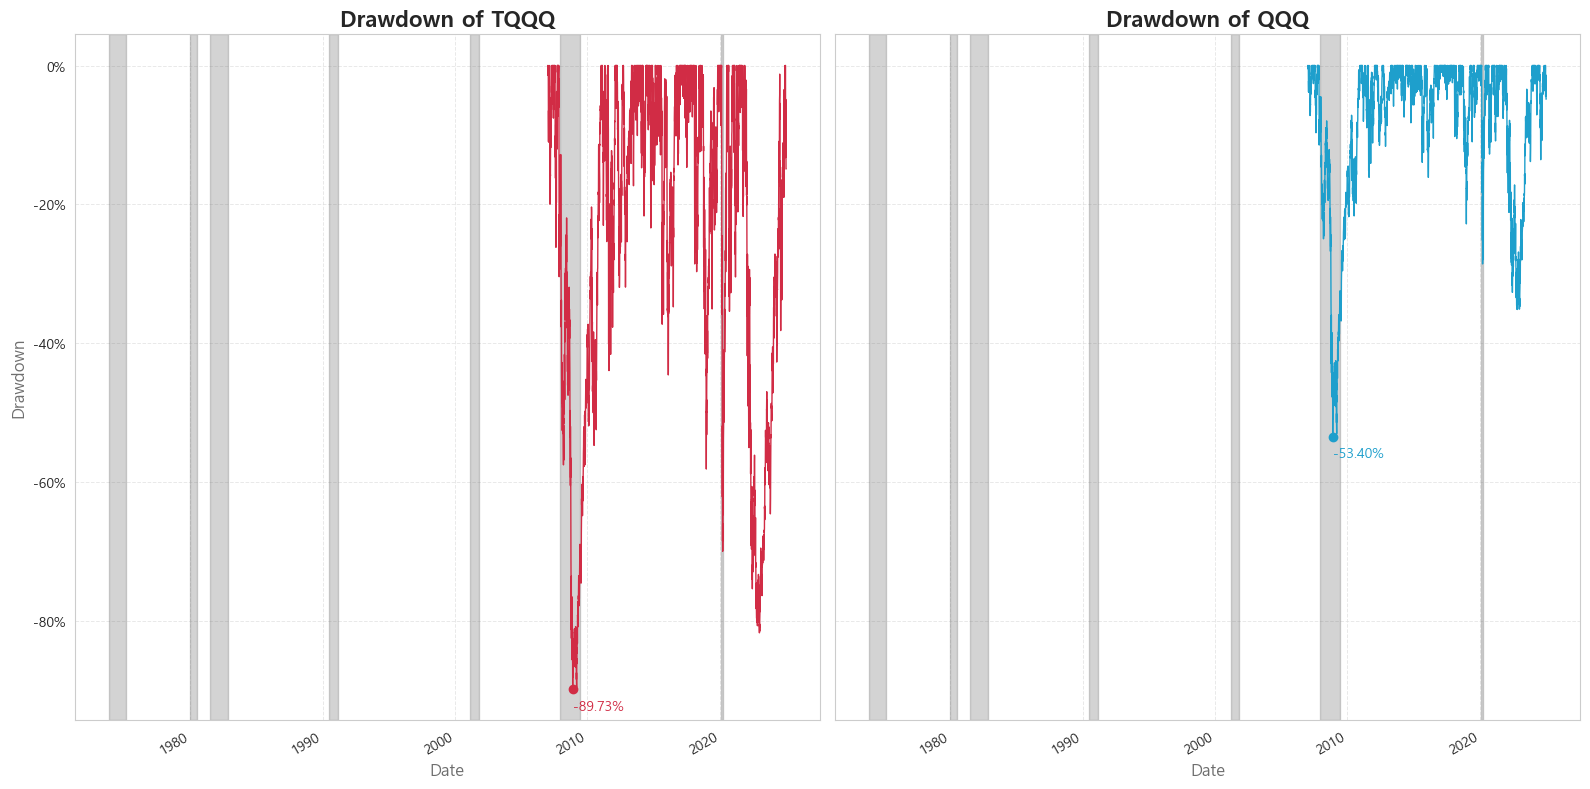

In [219]:
gm.drawdown_plot(plot_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']], highlight_periods=highlight_periods)

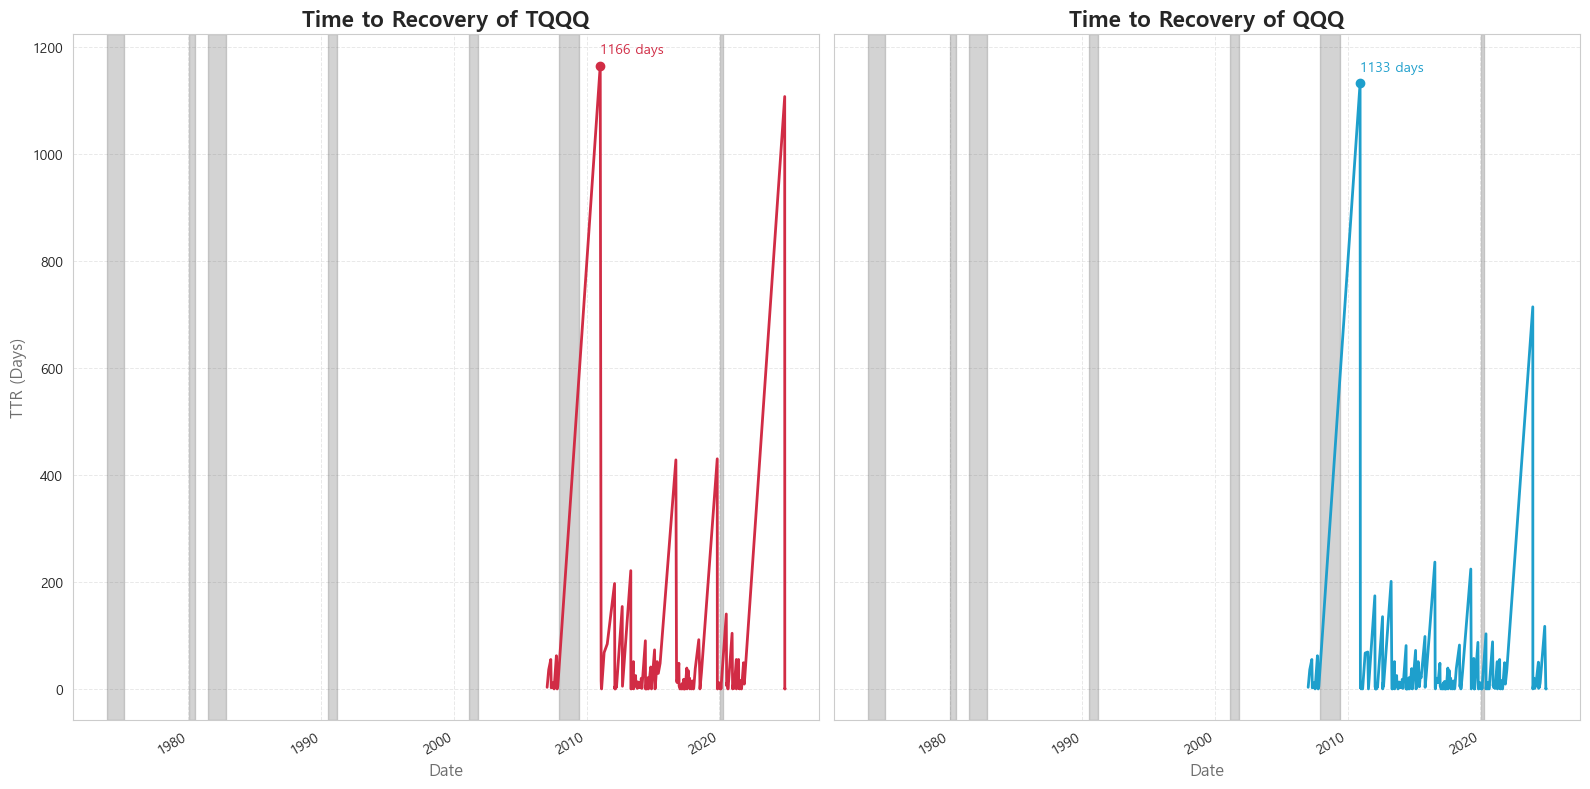

In [220]:
ttr_df = myfuncs.get_ttr_df(plot_df, assets)

gm.ttr_plot(ttr_df, assets, highlight_periods=highlight_periods, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

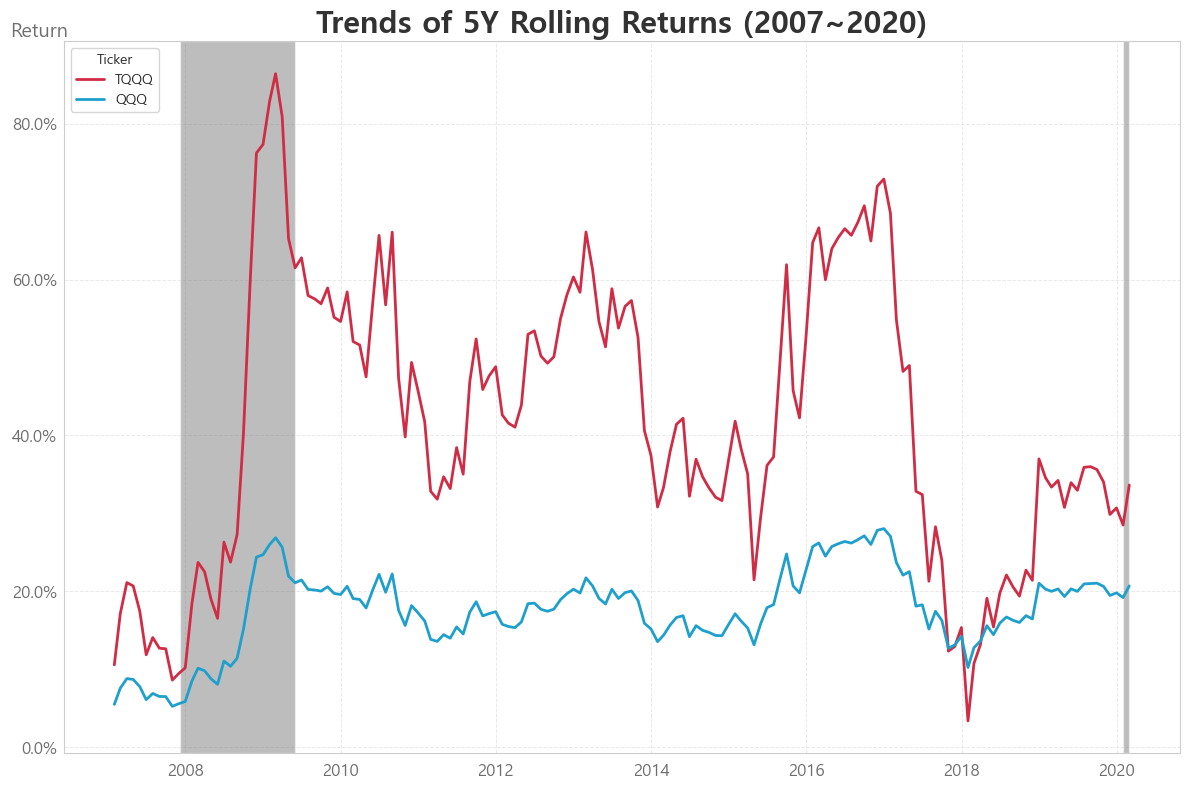

In [221]:
rr_df = myfuncs.get_rr_df(plot_df, assets)
gm.rr_trend_plot(rr_df, assets, highlight_periods=highlight_periods, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

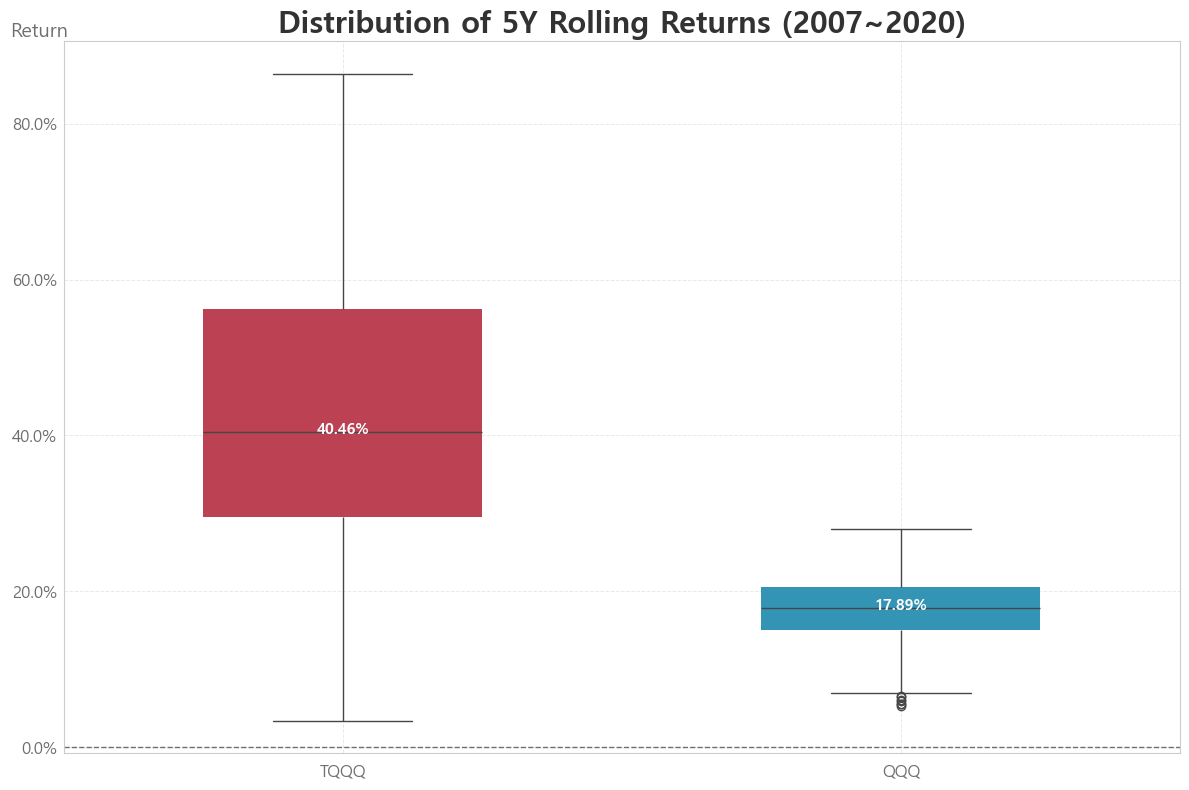

In [222]:
gm.rr_box_plot(rr_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

In [223]:
assets_port = assets + ['TLT', 'Gold']
assets_port = ['TQQQ','QQQ']

In [224]:
def corr_plot(corr_df, cmap=None):
    # cmap이 None이면 기본 컬러맵 설정
    if cmap is None:
        custom_colors = ["#F7FBFF", "#6BAED6", "#08306B"]
        cmap = LinearSegmentedColormap.from_list("custom", custom_colors)

    # 히트맵 시각화
    plt.figure(figsize=figsize)
    sns.heatmap(corr_df, annot=True, cmap=cmap, fmt='.2f',
                linewidths=0.5, cbar_kws={"shrink": .8}, cbar=False, annot_kws={"size": 40})
    plt.title('Asset Correlations', fontsize=40, fontweight="bold", color=mycolors['color_basic'])
    plt.ylabel("Assets", fontsize=40, labelpad=-50, color=mycolors['color_around'], loc="top", rotation=0)
    plt.xlabel("")
    plt.yticks(rotation=0, fontsize=40, color=mycolors['color_around'])
    plt.xticks(rotation=0, fontsize=40, color=mycolors['color_around'])
    plt.tight_layout()
    plt.show()

In [225]:
# corr_df = plot_df.pct_change()[assets_port].corr()
# corr_plot(corr_df, cmap=custom_cmap)

## Optimization

In [226]:
assets_port = ['QQQ', 'TQQQ', 'TLT', 'Gold']

In [227]:
df_imp_m = plot_df[assets_port].resample('M').last()

In [228]:
allocator = portfolio_obtimizer.PortfolioAllocator()

cal_optimal => eg. process, obtimal, min_risk = cal_optimal(df)
eg. process, obtimal, min_risk = cal_optimal(df)


In [264]:
process, obtimal, min_risk = allocator.cal_optimal(df_imp_m, unit='monthly', rebalancing='m', d=10, min_edge=0)

총 286번 시행 예정
1번째 시행 중
100번째 시행 중
200번째 시행 중


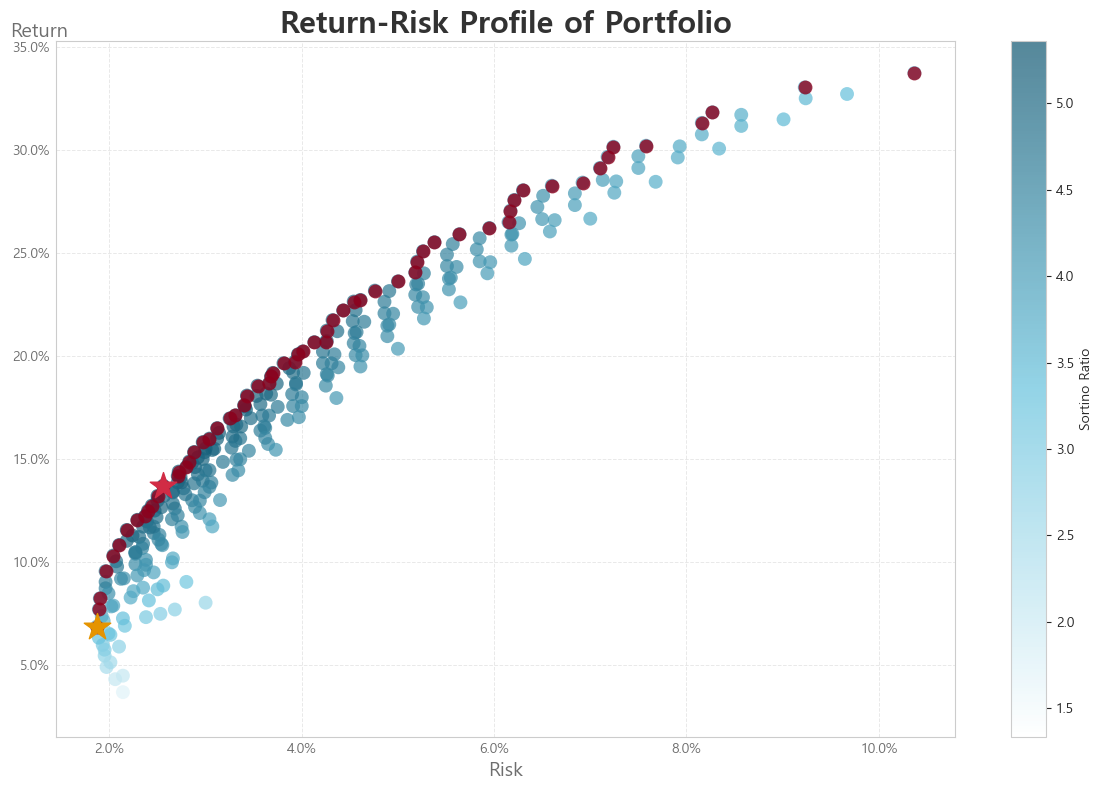

In [265]:
gm.portfilio_return_risk_profile_plot(process, obtimal, min_risk, cmap=custom_cmap)
# gm.portfilio_return_risk_profile_plot(process, min_risk, min_risk, cmap=custom_cmap)

In [266]:
obtimal

,QQQ,TQQQ,TLT,Gold,Return,Volatility,Volatility(Down),Sharpe Ratio,Sortino Ratio,Point
0,0.3,0.1,0.2,0.4,13.71,4.06,2.56,3.38,5.36,Obtimal


In [314]:
## ratio 임의 조정시
ratio = [0.0, 0.3, 0.35, 0.35]
result = allocator.cal_rebalancing(plot_df[df_imp_m.columns], ratio=ratio, rebalancing='m', unit='daily')
result.rename(columns={'strategy':'Portfolio'}, inplace=True)
result = result/result.iloc[0]*100

In [315]:
port_assets = ['Portfolio'] + assets
port_assets_sp = ['Portfolio', 'QQQ']

In [316]:
# ## ratio 임의 조정시
# ratio = [0, .7, 0.15, 0.15]
# result = allocator.cal_rebalancing(plot_df[df_imp_m.columns], ratio=ratio, rebalancing=None, unit='daily')
# result.rename(columns={'strategy':'QQQ+TLT+Gold'}, inplace=True)
# res1 = result/result.iloc[0]*100

# ## ratio 임의 조정시
# ratio = [0.8, .2, 0, 0]
# result = allocator.cal_rebalancing(plot_df[df_imp_m.columns], ratio=ratio, rebalancing=None, unit='daily')
# result.rename(columns={'strategy':'SCHD+QQQ'}, inplace=True)
# res2 = result/result.iloc[0]*100

# res2['QQQ+TLT+Gold'] = res1['QQQ+TLT+Gold']
# result = res2

# last_cols = ['QQQ+TLT+Gold', 'SCHD+QQQ', 'SCHD' ,'QQQ']
# last_cols_sp = ['QQQ+TLT+Gold', 'SCHD+QQQ']

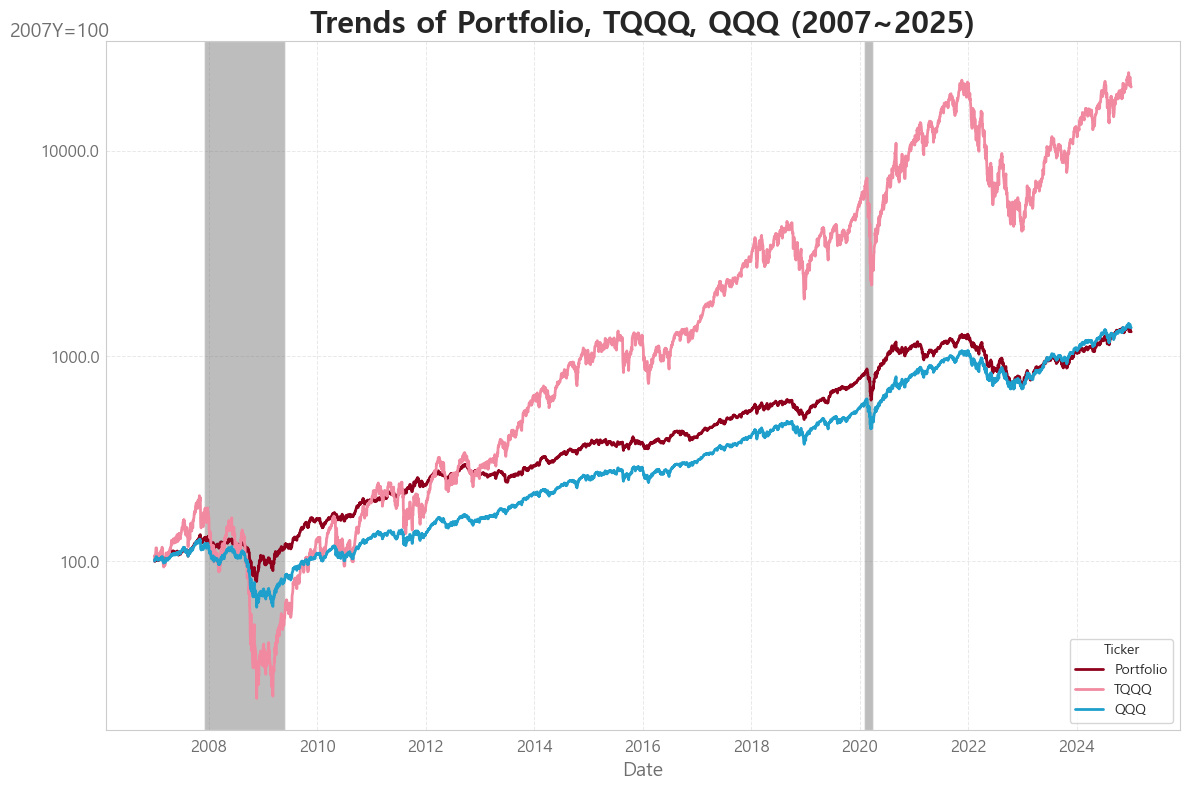

In [317]:
gm.trend_plot(result, port_assets, highlight_periods=highlight_periods, colors=[mycolors['color_norm2'], mycolors['color_norm3'], mycolors['color_cont'], mycolors['color_sub']])

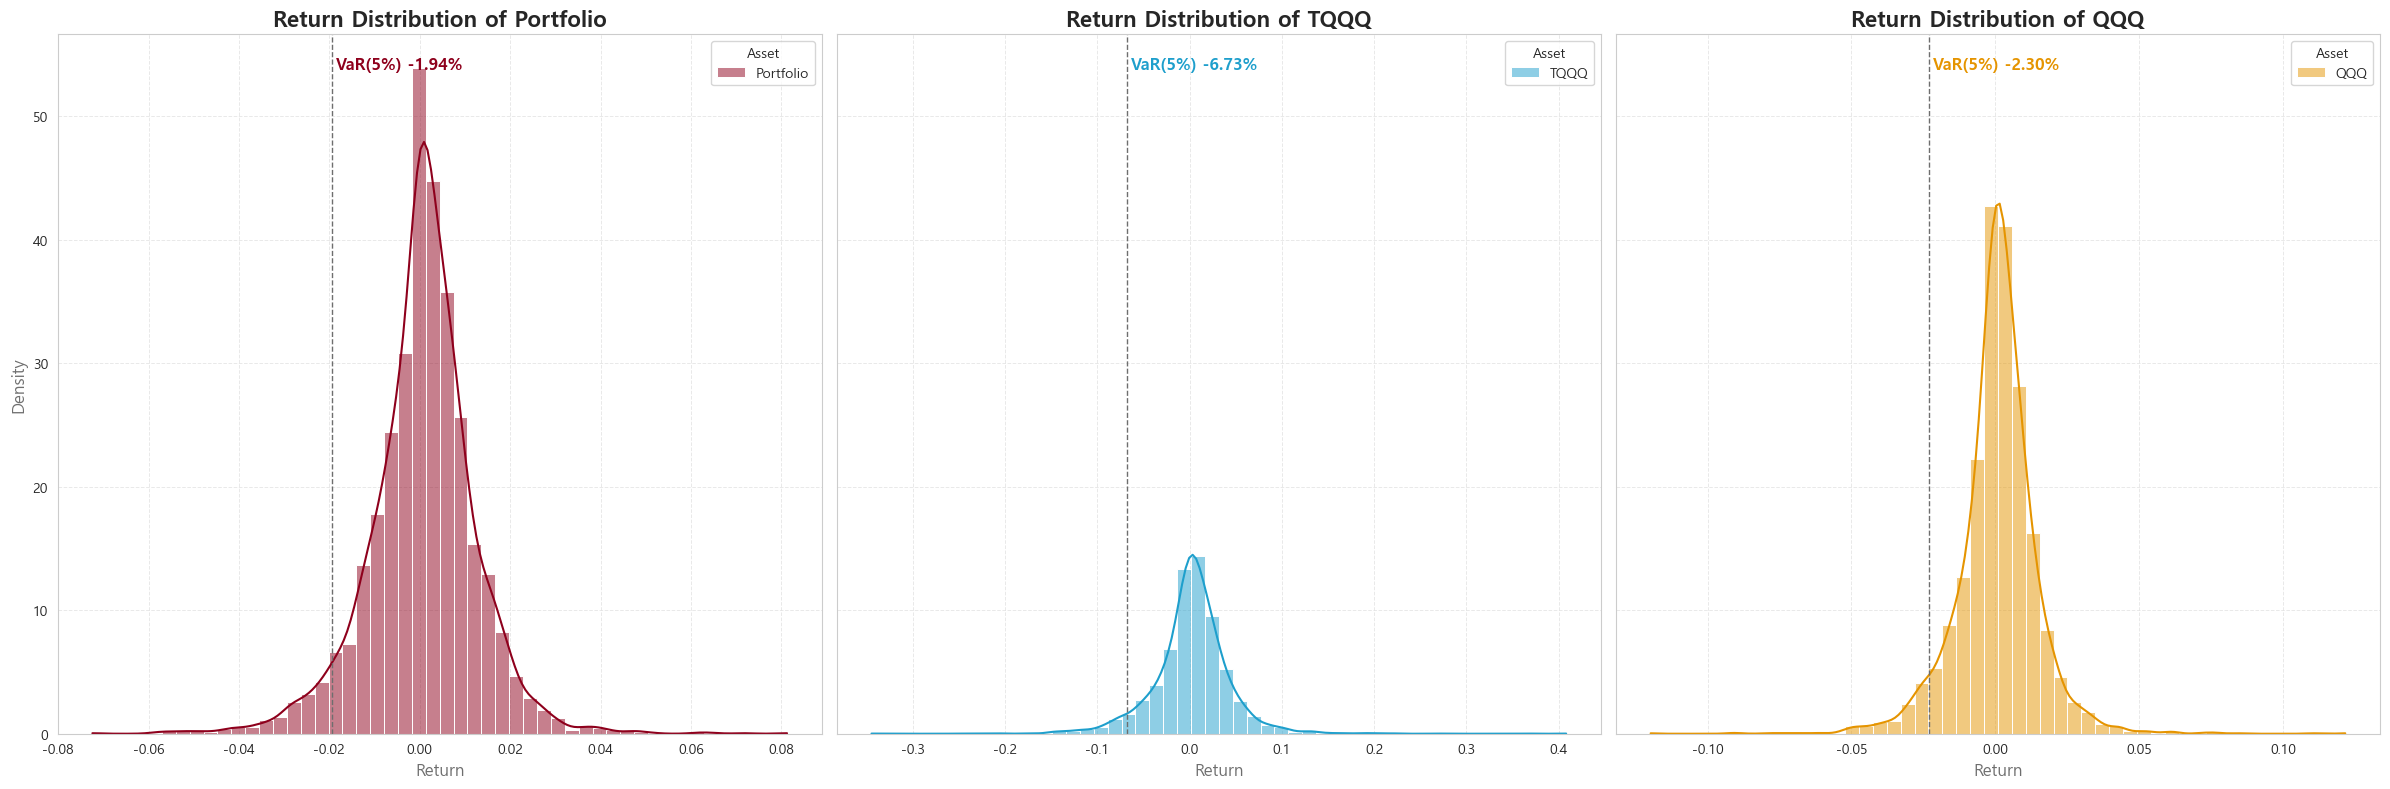

In [318]:
gm.asset_histogram_plot(result.pct_change(), port_assets, colors=[mycolors['color_norm2'], mycolors['color_cont'], mycolors['color_sub']])

In [319]:
## gm.asset_histogram_merged_plot(result.pct_change(), port_assets, colors=[mycolors['color_norm2'], mycolors['color_cont'], mycolors['color_sub']])

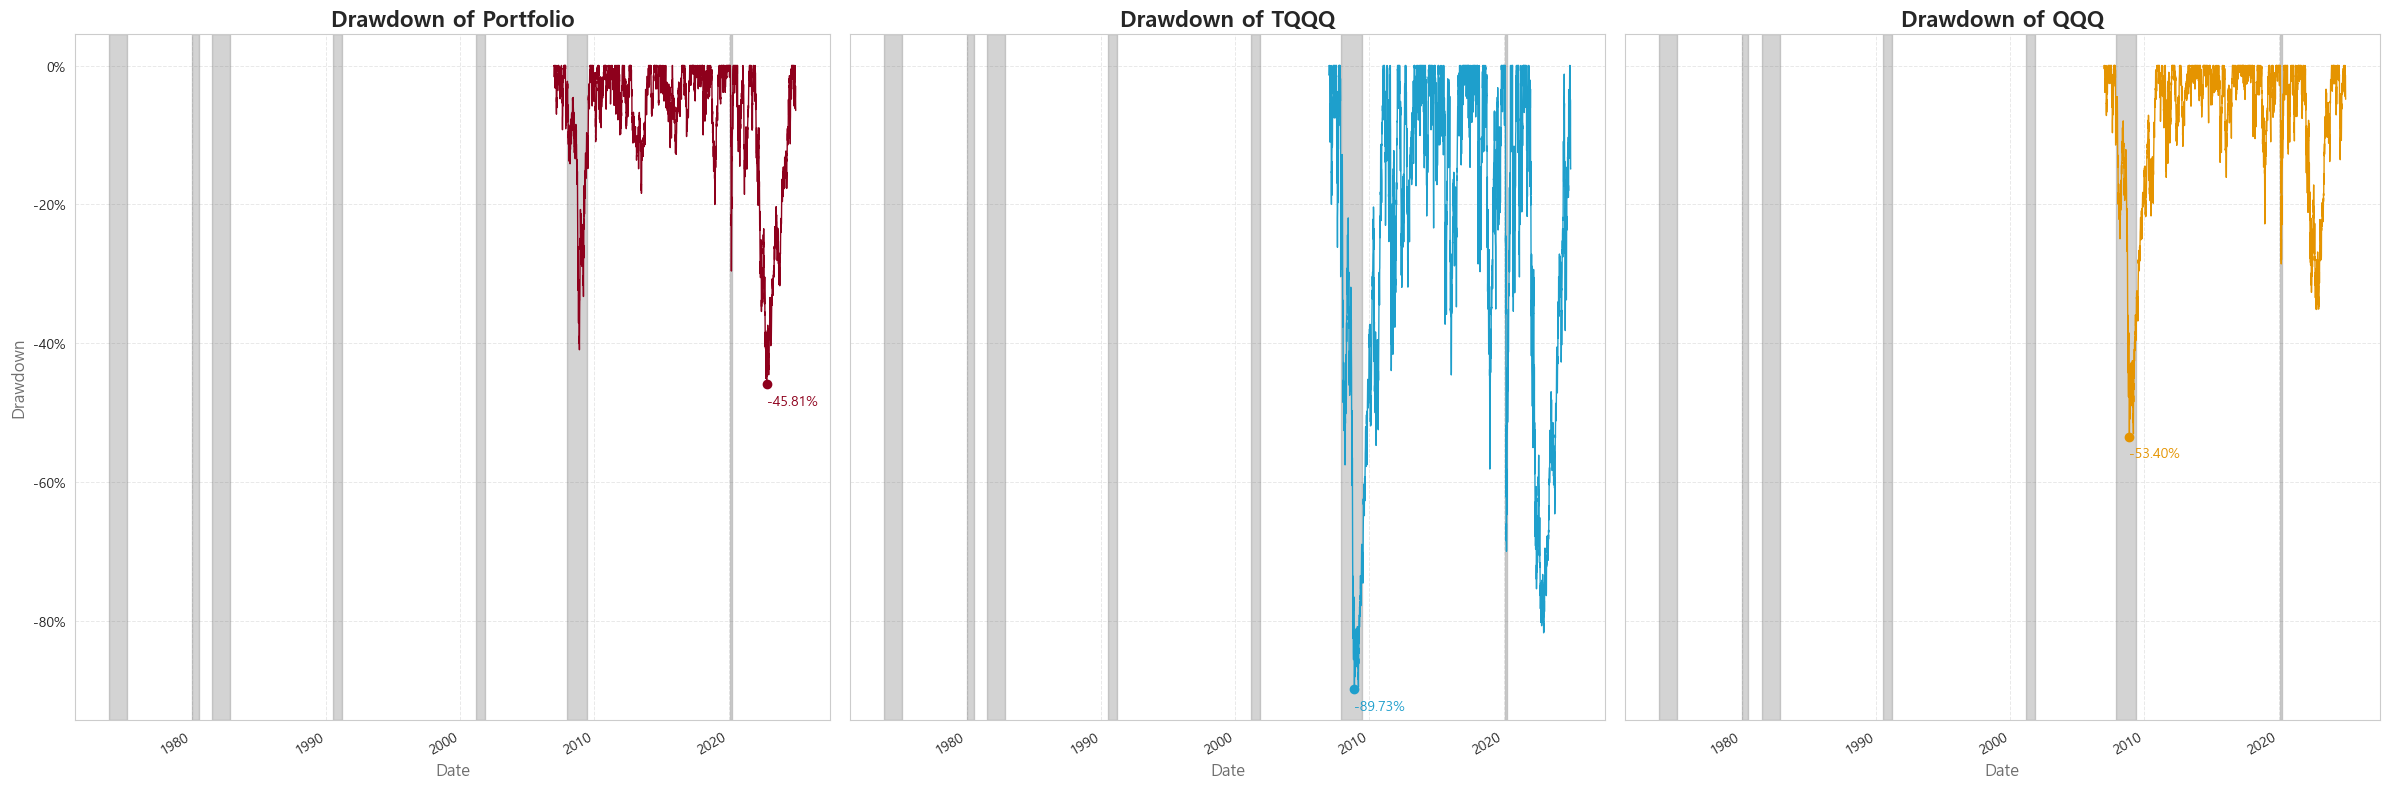

In [320]:
gm.drawdown_plot(result, port_assets, highlight_periods=highlight_periods, colors=[mycolors['color_norm2'], mycolors['color_cont'], mycolors['color_sub']])

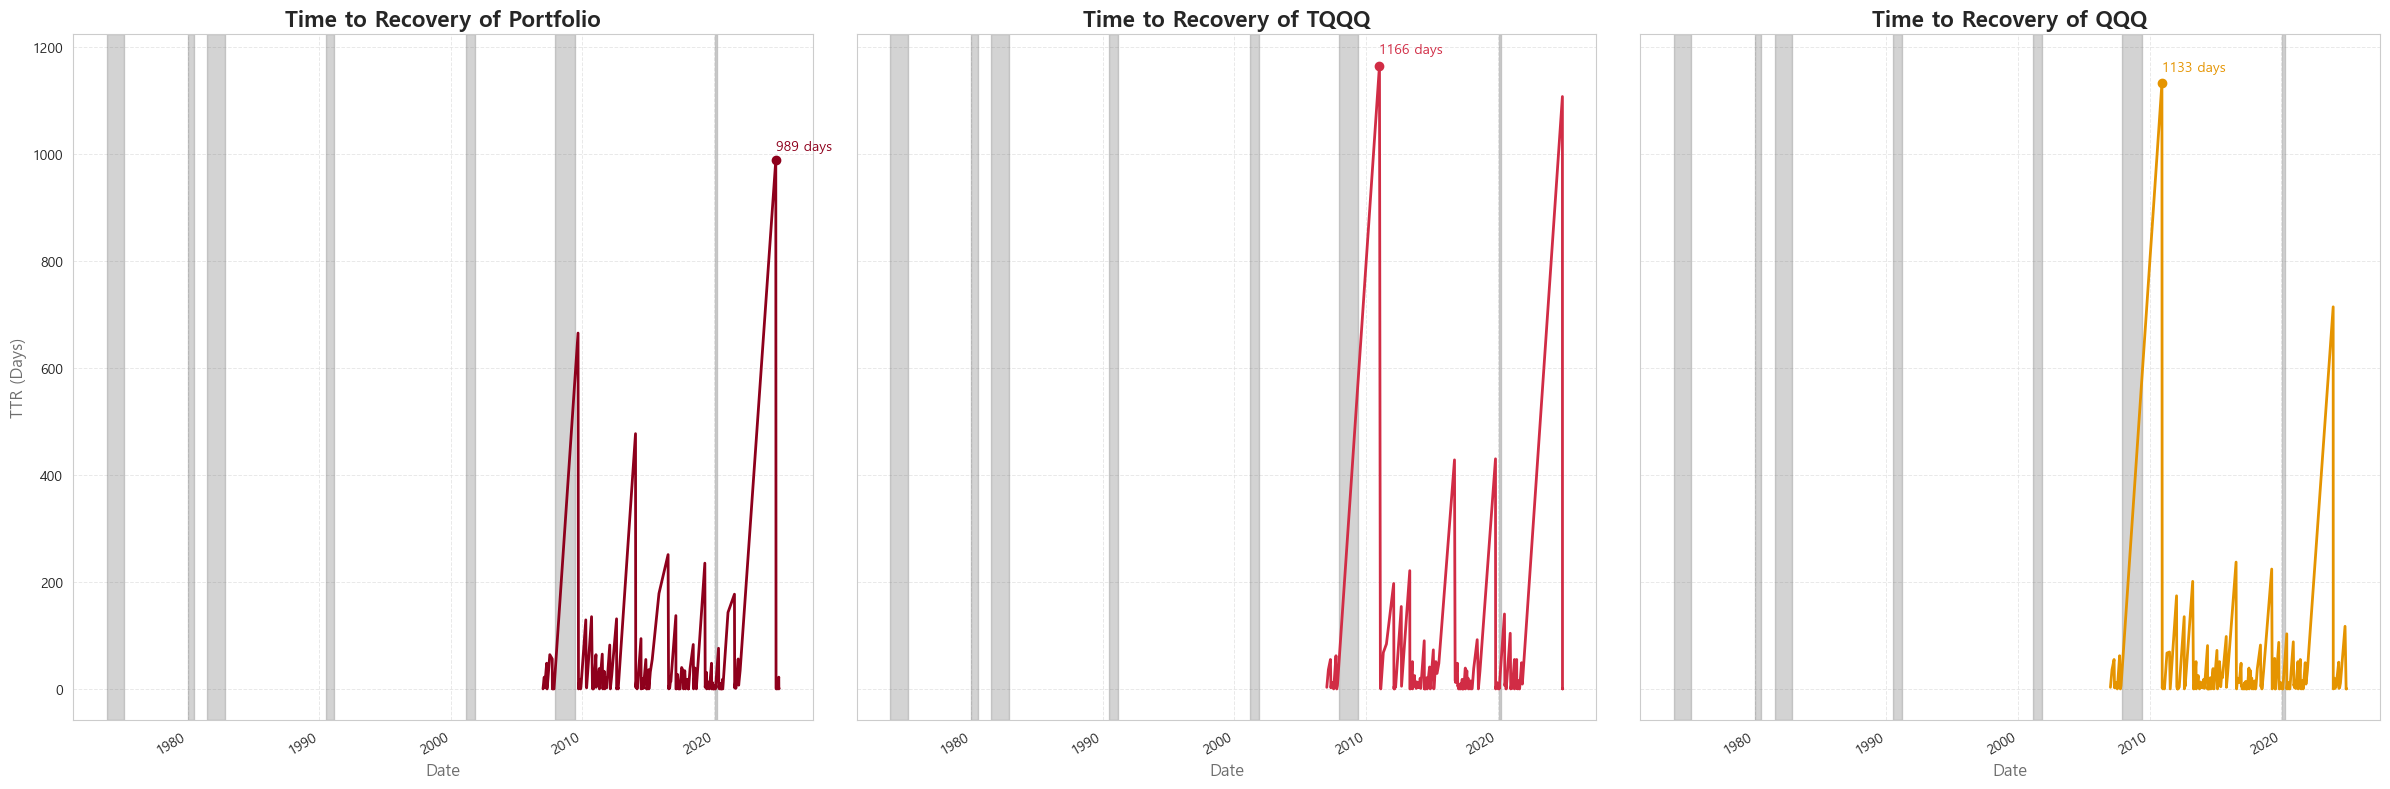

In [321]:
ttr_df = myfuncs.get_ttr_df(result, port_assets)
gm.ttr_plot(ttr_df, port_assets, highlight_periods=highlight_periods, colors=[mycolors['color_norm2'], mycolors['color_norm'], mycolors['color_sub']])

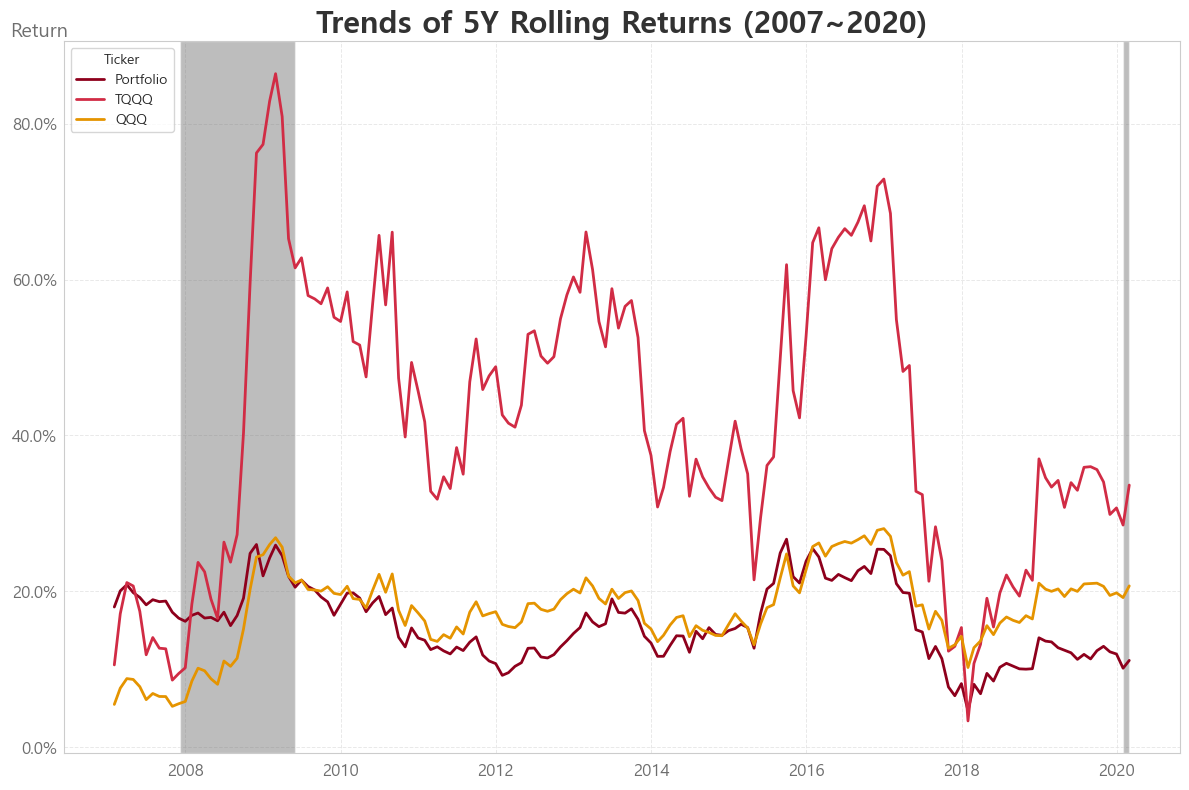

In [322]:
rr_df = myfuncs.get_rr_df(result, port_assets)
gm.rr_trend_plot(rr_df, port_assets, highlight_periods=highlight_periods, colors=[mycolors['color_norm2'], mycolors['color_norm'], mycolors['color_sub']])

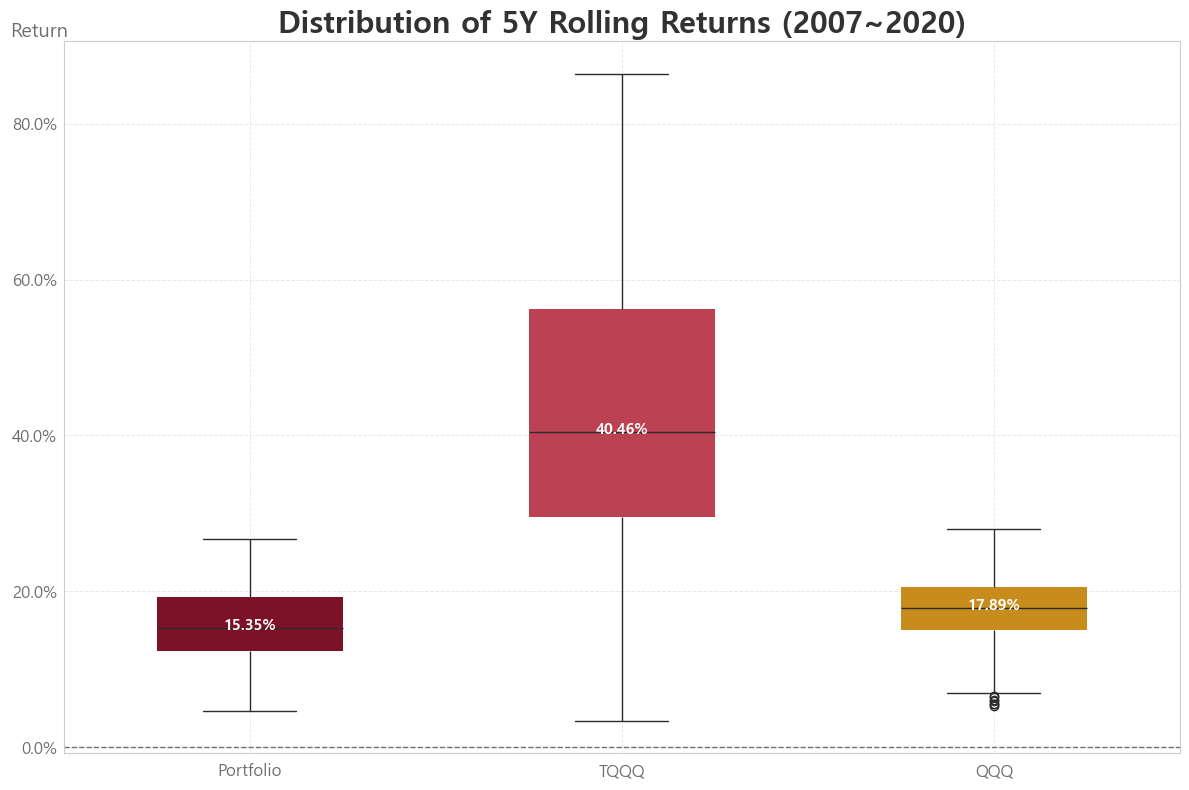

In [323]:
gm.rr_box_plot(rr_df, port_assets, colors=[mycolors['color_norm2'], mycolors['color_norm'], mycolors['color_sub']])

In [330]:
bm_ratios = {'0:5:5': [0, 0, 0.5, 0.5], 
             '10:45:45': [0, 0.1, 0.45, 0.45], '20:40:40': [0, 0.2, 0.4, 0.4],
             '30:35:35': [0, 0.3, 0.35, 0.35], '40:30:30': [0, 0.4, 0.3, 0.3],
             '50:25:25': [0, 0.5, 0.25, 0.25], '60:20:20': [0, 0.6, 0.2, 0.2],
             '70:15:15': [0, 0.7, 0.15, 0.15], '80:10:10': [0, 0.8, 0.1, 0.1],
             '90:5:5': [0, 0.9, 0.05, 0.05]}


ls = {}
for _key in bm_ratios.keys():
    ratio = bm_ratios[_key]
    result = allocator.cal_rebalancing(df_imp_m[df_imp_m.columns], ratio=ratio, rebalancing='m', unit='monthly')
    result.rename(columns={'strategy':'Portfolio'}, inplace=True)
    result = result/result.iloc[0]*100
    ls[_key] = result['Portfolio']

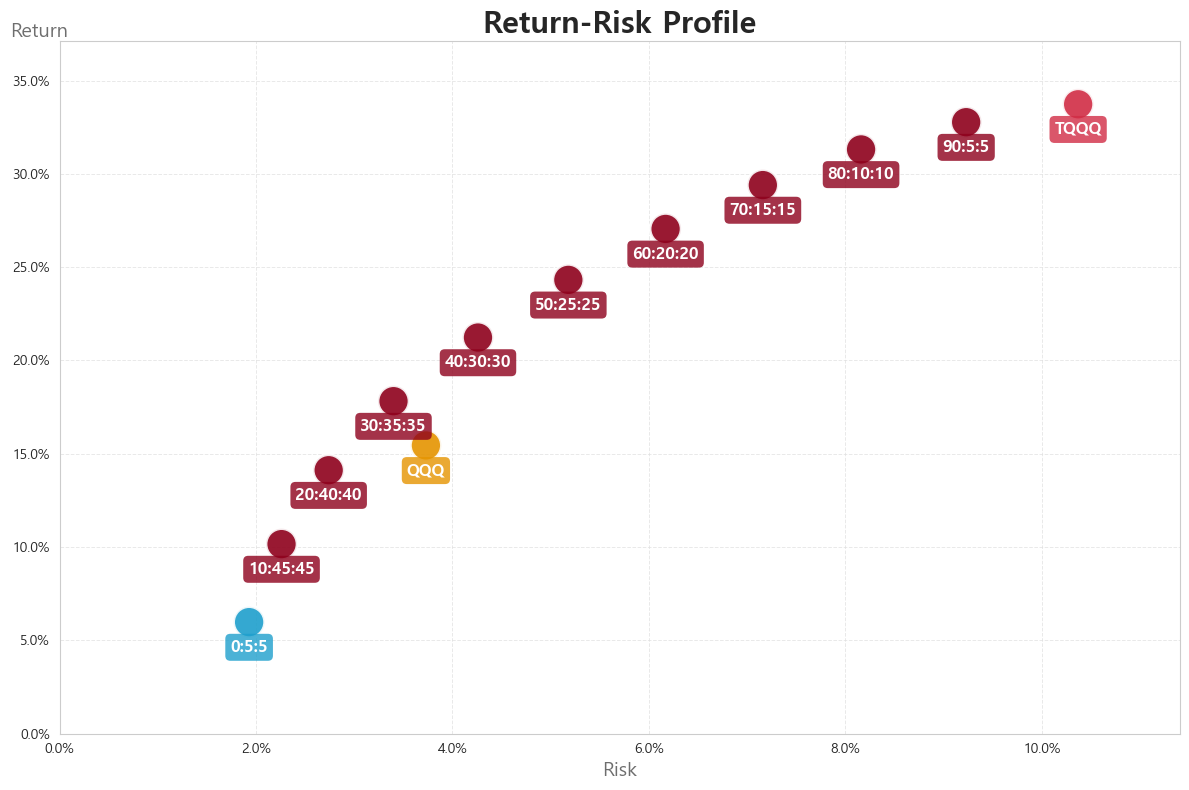

In [331]:
rr_res = pd.DataFrame(ls)
rr_res['QQQ'] = result['QQQ']
rr_res['TQQQ'] = result['TQQQ']


return_risk_df = anal_funcs.get_Vol_report(rr_res, unit='monthly', method='a', rf=0)

gm.return_risk_profile_plot(
    return_risk_df,
    list(return_risk_df.index),
    colors=[
        mycolors["color_cont"],
        mycolors["color_norm2"],
        mycolors["color_norm2"],
        mycolors["color_norm2"],
        mycolors["color_norm2"],
        mycolors["color_norm2"],
        mycolors["color_norm2"],
        mycolors["color_norm2"],
        mycolors["color_norm2"],
        mycolors["color_norm2"],
        mycolors["color_sub"],
        mycolors["color_norm"],
    ],
)

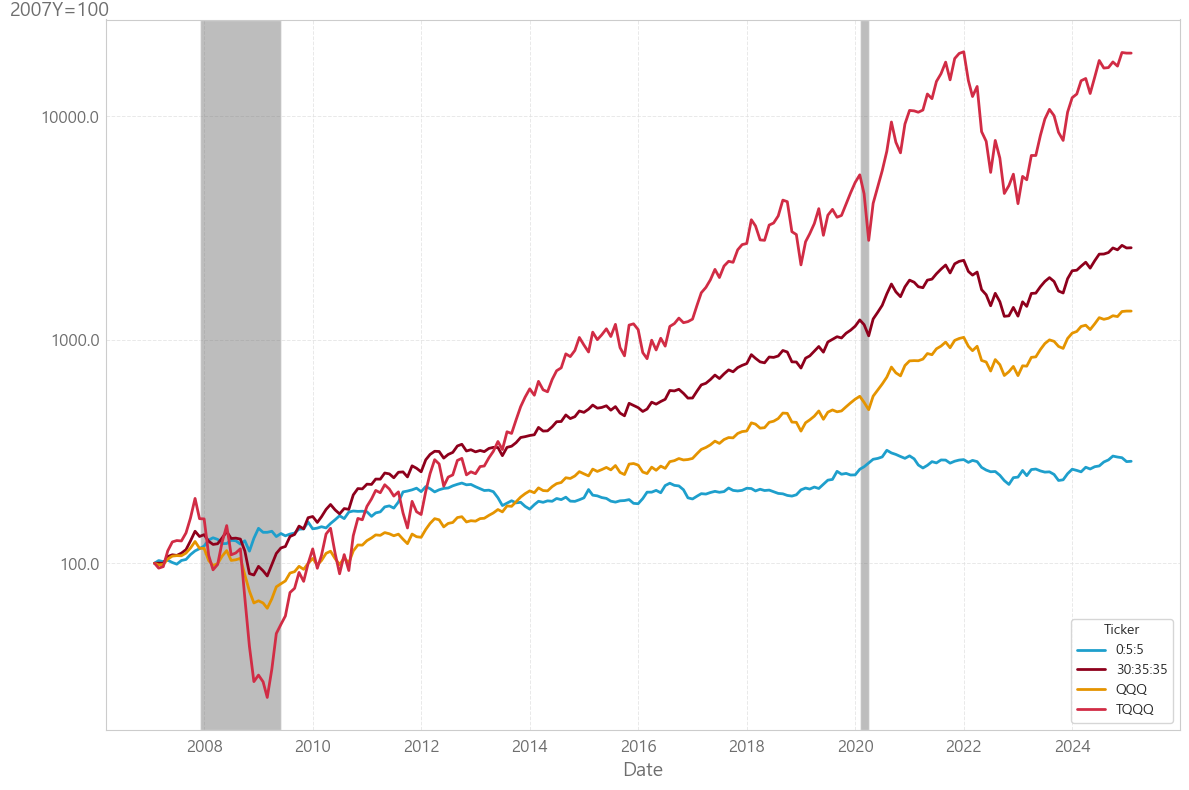

In [329]:
target = '30:35:35'

gm.trend_plot(
    rr_res,
    ['0:5:5', target, 'QQQ', 'TQQQ'],
    highlight_periods=highlight_periods,
    colors=[
        mycolors["color_cont"],
        mycolors["color_norm2"],
        mycolors["color_sub"],
        mycolors["color_norm"],
    ], title=False
)

In [265]:
rr_res

,0:5:5,10:45:45,20:40:40,30:35:35,40:30:30,50:25:25,60:20:20,70:15:15,80:10:10,90:5:5,QQQ,TQQQ
Date,,,,,,,,,,,,
1975-01-31,100.000000,100.000000,100.000000,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,100.000000,1.000000e+02
1975-02-28,99.359829,100.932354,102.504879,104.077403,1.056499e+02,1.072225e+02,1.087950e+02,1.103675e+02,1.119400e+02,1.135126e+02,104.826564,1.150851e+02
1975-03-31,97.069897,100.028979,103.032396,106.080147,1.091722e+02,1.123087e+02,1.154894e+02,1.187145e+02,1.219839e+02,1.252977e+02,108.820965,1.286558e+02
1975-04-30,93.150240,97.628028,102.246736,107.008541,1.119156e+02,1.169702e+02,1.221743e+02,1.275303e+02,1.330403e+02,1.387064e+02,113.152828,1.445309e+02
1975-05-31,94.331458,100.618308,107.213663,114.127434,1.213697e+02,1.289506e+02,1.368807e+02,1.451704e+02,1.538303e+02,1.628715e+02,120.026115,1.723048e+02
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-30,825.389251,8837.419528,75932.056829,525232.552496,2.928362e+06,1.314861e+07,4.740230e+07,1.364502e+08,3.109302e+08,5.538476e+08,46019.973566,7.572796e+08
2024-10-31,817.145234,8720.916608,74688.457681,514952.351709,2.861691e+06,1.280724e+07,4.602017e+07,1.320357e+08,2.998775e+08,5.323904e+08,45622.072006,7.255217e+08
2024-11-30,811.566823,8798.431208,76526.048977,535714.447815,3.022042e+06,1.372614e+07,5.004527e+07,1.456590e+08,3.355311e+08,6.040549e+08,48063.230268,8.345850e+08


In [376]:
rr_df['Portfolio'].describe()

count    253.000000
mean      10.930173
std        4.497749
min       -1.963317
25%        7.355241
50%       11.277106
75%       13.593515
max       24.057869
Name: Portfolio, dtype: float64

In [377]:
rr_df['SCHD'].describe()

count    253.000000
mean      10.644312
std        4.034407
min       -1.476119
25%        8.486104
50%       10.770841
75%       13.374409
max       23.267830
Name: SCHD, dtype: float64